# Neighborhoods of Hamburg - Which one is for you?
Capstone project for Coursera course [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone/home/welcome)

By Nima Mehrafshan

Hamburg, 7 October 2019

## 1 The Business Problem

Deciding which neighborhood to live in or where to buy property is a difficult task, especially if you don't know the ins and outs of the city you're looking at. There are so many factors that may influence your decision and the factors may be different for each decision maker depending on their goals, tastes, preferences and individual situation. Those factors may include the accessibility of the location, distance and quality of schools, the availability of restaurants and cafés, property prices and expectations of future development, the type of people you typically meet in the area, and so on. In this project, I'd like to explore the 104 neighborhoods of my home town Hamburg (Germany), and see how data could help to make decisions like that.

I will take the position of a home buyer here because I think everyone can relate to this decision situation. But I think the same analysis would also be relevant to an investor or even to the city administration, who could use it to support their urban development decisions.

So the main questions, I will try to answer are: 
1. What are the main drivers of real estate prices in Hamburg?
2. Which neighborhoods are undervalued, when relating their attributes to current average property prices?
3. How can neighborhoods be characterized? Can the 100+ neighborhoods be clustered by similarity into a managable number of groups, in order to get a quick understanding of what they are like?

##  2 Research Outline

1) To answer question one I will estimate a random forest model with property price levels as the target and the socio-economics as well as the points-of-interest as features (hedonic pricing model). I will then extract the importances from the model to identify the main drivers of property prices in Hamburg. The direction of the relationship From can then be derived from the correlations of these features with the price levels.

2) For question two I will predict price levels for all neighborhoods using the model from above and use the residuals as an indicator of under or overvaluation.

3) I will use the relevant features derived in 1) to run a KMeans cluster analysis and then characterize the resulting clusters based on the most prevalent differences of the clusters compared with the city average.

## 3 Data

I will need data about average prices in the neighborhoods and about as many neighborhood characteristics as possible. I found three main data sources that I will deploy in the analysis:

- Socio-economic data from "Statistikamt Nord" (https://www.statistik-nord.de), the statistics office for the Bundesländer (German states) Hamburg and Schleswig-Holstein. They provide over 70 socio-economic variables for the years 2013 - 2017, including average household income, number of schools (by type of school), average household size, unemployment rates, and many more. The data set also includes _average property prices per m²_ !
- Points of interest from the Foursquare API (https://developer.foursquare.com), such as restaurants, grocery stoes, nightlife venues, etc.
- The borders of the Hamburg neighborhoods in a digital format from the land surveying office ("Landesbetrieb Geoinformation und Vermessung", https://www.hamburg.de/bsw/landesbetrieb-geoinformation-und-vermessung), which I will use for plotting and to link the Foursquare venues to the neighborhoods.

### 3.1 Data Acquisition

Lets load the libraries that I will use throughout this notebook. Note that I have outsourced some functions to a file I called "util", in order not to clutter this notebook with code not core to the analyses.

In [2]:
%load_ext autoreload
%autoreload 2

from shapely.geometry import MultiPolygon

import folium

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
#from autoimpute.imputations import SingleImputer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Outsourced utility functions
from util import *

# Constants
SOCIOECON_IMPUTED_PKL_FILE = "data/hamburg_socioecon_imputed.pkl"
SOCIOECON_PREPARED_PKL_FILE = "data/hamburg_socioecon_prepared.pkl"
SHAPES_JSON_FILE = "data/hamburg_quarters.json"
VENUE_COUNTS_PKL_FILE = "out/venue_counts.pkl"

#### 3.1.1 Neighborhood Shapes

To get the neighborhood shapes I'm using the [WFS service](https://en.wikipedia.org/wiki/Web_Feature_Service) of the land surveying office, transform it into a GeoDataFrame and store the result in a geoJSON file.

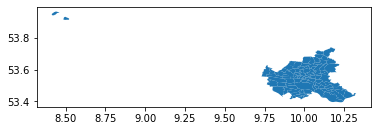

In [208]:
j = get_geodata(name=SERVICE_NAME, service="WFS", type_name="app:stadtteile")
shapes = gpd.read_file(j)
shapes.to_file(SHAPES_JSON_FILE, driver='GeoJSON')
shapes.plot()

The plot shows that the exclave neighborhood "Neuwerk" is included in the data. Even though it legally belongs to Hamburg, it has litte relevance with only ~50 inhabitants, so let's remove it.

In [287]:
shapes = shapes.cx[9.5:, :] # drop Neuwerk

#### 3.1.2 Socio-economic Data

Next I'll get the socio-economic data from the statistics office. It is provided as Excel files. I wrote a function `import_socioecon_data` that takes care of a number of things:
- Downloading the files and reading the data
- Storing meta data, such as the source variable names and descriptions, into a file
- Translating the variable names and descriptions to English using the Google Translator API
- Reading in the meta data file if the function is being run a second time and using the variable names that I have edited in the meantime
- Merging the data from the different files
- Specifying the administrative levels (the data contains data on neighborhoods, city districts and the city as a whole)
- Saving the data as a pickle file

In [175]:
data = import_socioecon_data()
FIRST_YEAR = data.year.min()
LAST_YEAR = data.year.max()
data.shape

(535, 79)

#### 3.1.1 Points of interest

Now to the Foursquare API. I went through the list of Foursquare's venue categories and selected those I thought of being particularly relevant for buyers of apartments or houses. I grouped those categories into six topics:

- Groceries
    - Supermarket
    - Grocery Store
    - Organic Grocery
- Education
    - High School
    - Middle School
    - Child Care Service
    - Playground
- Health
    - Physical Therapist
    - Doctor's Office
- Public Transportation
    - Bus Stop
    - Light Rail Station
    - Metro Station
    - Train Station
- Gastronomy
    - Food
- Nightlife 
    - Nightlife Spot

So, I want to get all venues from these categories in Hamburg. Since the API has a limit of 50 results per request, it's not enough to do one request per neighborhood if you don't want to miss out on any venues, because there will of course be more then 50 venues probably in most neighborhoods. Thus, I wrote a function `get_foursquare_data` that loops through smaller raster segments of Hamburg, making a request for each of the topics and if the API returns 50 results, it devides the segment in smaller ones until there are less then 50 results per segment and topic. I start with a raster of 1,000 segments:

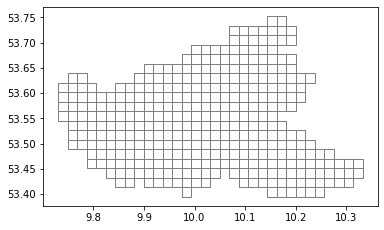

In [185]:
raster = create_raster(data.unary_union, 1000).plot(facecolor="none", edgecolor='grey')

Now, let's run the function to get the venues:

In [ ]:
venues = get_foursquare_data(raster, CATEGORY_SELECTION.keys())

Let's create a DataFrame with all venues, spatially merge it with the neighborhood shapes, and plot them. 

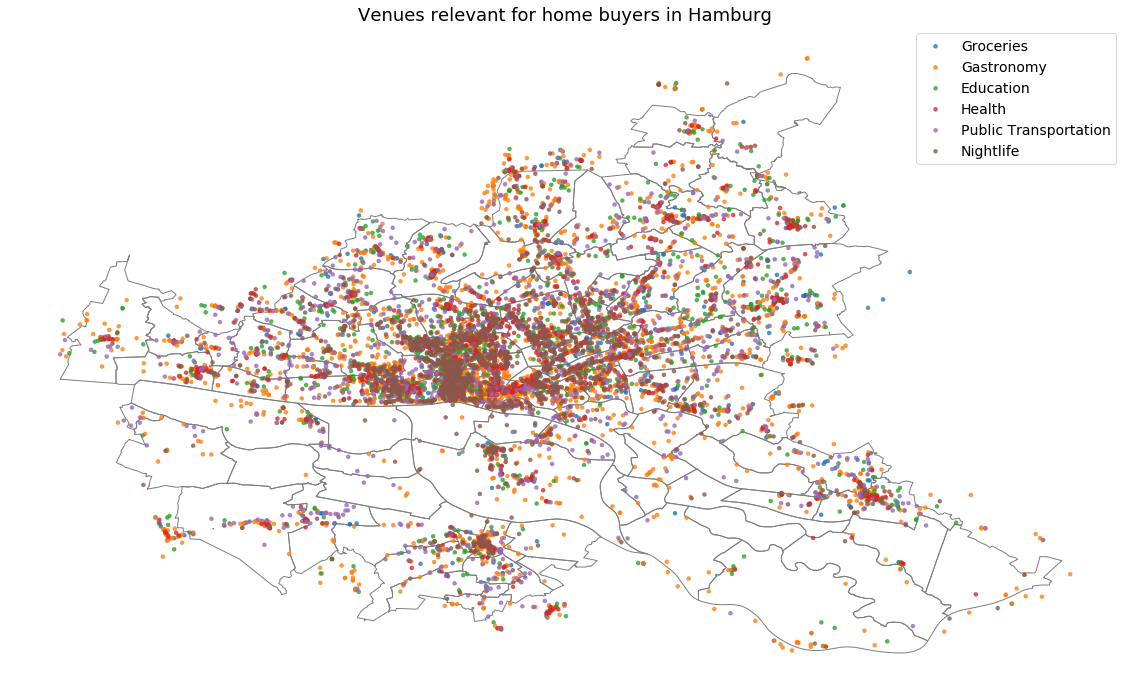

In [289]:
with open(FOURSQUARE_DATA_FILE, 'rb') as f:
    venues = pickle.load(f)

df_list = []
for k, v in venues.items():
    el = {
        "id": k,
        "name": v['name'],
        "lat": v['location']['lat'], 
        "lng": v['location']['lng'],
        "topic": v["topic"],
        "category": v['categories'][0]['name'],
        "category_id": v['categories'][0]['id']
    }
    
    df_list.append(el)
    
venues = pd.DataFrame.from_records(df_list)
venues = gpd.GeoDataFrame(venues.drop(columns=["lng", "lat"]), geometry=gpd.points_from_xy(venues.lng, venues.lat))
venues.crs = {'init' :'epsg:4326'}

ax = shapes.plot(facecolor="none", edgecolor="grey", figsize=(20,15))
for topic in venues.topic.unique():
    venues[venues.topic == topic].plot(ax=ax, edgecolor="none", markersize=20, alpha=0.8, label=topic)

ax.legend(fontsize=14)
ax.set_title('Venues relevant for home buyers in Hamburg', fontsize=18)
ax.set_axis_off()

### 3.2 Data preparation

The socio-economics data is in long format with a row for each year of data for every neighborhood:

In [233]:
data = pd.read_pickle(SOCIOECON_PKL_FILE)
data = data[data.admin_level > 9] # Drop the districts and city data
data = data.drop(columns="admin_level")

nh_and_year = [GEOGRAPHY_NAME, "year"]
data.sort_values(nh_and_year)[nh_and_year + data.columns.drop(nh_and_year).to_list()].head().round(2)

,name,year,area_in_km2,average_apartment_price_per_m2,average_apartment_size_m2,average_house_price_per_m2,average_household_size,average_income,average_land_price_per_m2,births,...,students_in_comprehensive_schools_pct,students_in_gymnasiums_pct,students_in_secondary_schools,taxpayers,unemployed_population,unemployed_population_pct,welfare_receivers,welfare_receivers_pct,youth_unemployed,youth_unemployment_pct
506,Allermöhe,2013,8.65,NaN,114.71,2126.0,2.10,35822,169.0,10,...,53.90,44.90,89,653,22,2.40,29,2.20,3.0,2.10
399,Allermöhe,2014,8.65,NaN,115.41,2287.0,2.08,35822,187.0,7,...,56.18,40.45,89,653,23,2.50,27,2.00,NaN,NaN
292,Allermöhe,2015,8.65,2351.0,115.41,2270.0,2.06,35822,164.0,7,...,67.03,30.77,91,653,25,2.63,26,1.88,3.0,1.64
185,Allermöhe,2016,8.64,NaN,115.19,2548.0,2.09,38369,203.0,9,...,61.45,36.14,83,696,17,1.84,34,2.50,0.0,0.00
78,Allermöhe,2017,8.64,3128.0,114.85,2751.0,2.06,38369,226.0,10,...,57.14,41.56,77,696,21,2.27,17,1.25,3.0,2.04


For the following analyses, I'm reshaping it to wide format with one column for each year and variable:

In [234]:
data = data.pivot_table(index=GEOGRAPHY_NAME, columns="year")
data.columns = ['_y'.join(col).strip() for col in data.columns.values]
data.head().round(2)

,area_in_km2_y2013,area_in_km2_y2014,area_in_km2_y2015,area_in_km2_y2016,area_in_km2_y2017,average_apartment_price_per_m2_y2013,average_apartment_price_per_m2_y2014,average_apartment_price_per_m2_y2015,average_apartment_price_per_m2_y2016,average_apartment_price_per_m2_y2017,...,youth_unemployed_y2013,youth_unemployed_y2014,youth_unemployed_y2015,youth_unemployed_y2016,youth_unemployed_y2017,youth_unemployment_pct_y2013,youth_unemployment_pct_y2014,youth_unemployment_pct_y2015,youth_unemployment_pct_y2016,youth_unemployment_pct_y2017
name,,,,,,,,,,,,,,,,,,,,,
Allermöhe,8.65,8.65,8.65,8.64,8.64,NaN,NaN,2351.0,NaN,3128.0,...,3.0,NaN,3.0,0.0,3.0,2.1,NaN,1.64,0.00,2.04
Alsterdorf,3.06,3.06,3.06,3.16,3.16,3239.0,3747.0,3891.0,4261.0,4486.0,...,18.0,25.0,17.0,27.0,32.0,1.4,1.81,1.21,1.82,2.03
Altengamme,15.61,15.61,15.61,15.61,15.61,NaN,NaN,NaN,NaN,NaN,...,3.0,8.0,4.0,4.0,0.0,1.3,3.27,1.68,1.68,0.00
Altona-Altstadt,2.75,2.75,2.75,2.72,2.72,4022.0,4053.0,4911.0,5745.0,6064.0,...,102.0,120.0,110.0,101.0,112.0,4.0,4.68,4.39,3.98,4.29
Altona-Nord,2.18,2.18,2.18,2.22,2.22,4022.0,4053.0,4911.0,5745.0,6064.0,...,79.0,59.0,72.0,66.0,61.0,3.9,2.94,3.58,3.29,2.91


As it turns out, there are some 700+ missing values in the data:

In [235]:
n_cells = data.shape[0]*data.shape[1]
n_missing = data.isna().sum().sum()

print(f"Missing values: {n_missing} ({round(n_missing/n_cells, 2)}%) of {n_cells}")

Missing values: 739 (0.02%) of 32868


I'll use the iterative imputation of sklearn to predict the missing values based on all available data.

In [237]:
imputer = IterativeImputer(max_iter=50)
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)
data.to_pickle(SOCIOECON_IMPUTED_PKL_FILE)

n_missing = data.isna().sum().sum()
print(f"Missing values: {n_missing} ({round(n_missing/n_cells, 2)}%) of {n_cells}")

Missing values: 0 (0.0%) of 32868


Most variables in the dataset are available in absolute terms and as a percentage of some base, e. g. the population under 15 on welfare (`population_under_15_on_welfare`) and the population under 15 on welfare as a percentage of the total population (`population_under_15_on_welfare_pct`). And after the reshape, there is now a column for each year. To simplify the dataset, I will calculate a 5 year change for all absolute variables and then drop them. I will also drop all but the 2017 versions of the variables.

In [291]:
data = pd.read_pickle(SOCIOECON_IMPUTED_PKL_FILE)

pct_cols = data.columns.str.contains("_pct")
ly_cols = data.columns.str.contains(f"_y{LAST_YEAR}$")
for col in data.columns[(~pct_cols) & ly_cols]:
    if re.search(f"_y{LAST_YEAR}$", col):
        col_fy = col.replace(LAST_YEAR, FIRST_YEAR)
        if col_fy in data.columns:
            new_col = col.replace(f"y{LAST_YEAR}", '5y_chg_pct')
            data.loc[data[col_fy] == 0, new_col] = 100   # Set to 100 % if prior year was 0
            data.loc[data[col_fy] != 0, new_col] = data[col]*100 / data[col_fy] - 1

pct_cols = data.columns.str.contains("_pct")
for col in data.columns[pct_cols]:
    col_np = col.replace("_pct", "")
    if col_np in data.columns:
        data = data.drop(columns=col_np)

ly_cols = data.columns.str.contains(f"_y{LAST_YEAR}$")
for col in data.columns[ly_cols]:
    col_np = re.sub(f"{LAST_YEAR}$", "", col)
    cols = data.columns.str.contains(col_np)
    cols = data.columns[cols]
    if col in cols:
        cols = cols.drop(col)
    data = data.drop(columns=cols)
    
data.columns = data.columns.str.replace("_y[0-9]{4}$", "")
data.head()

,area_in_km2,average_apartment_price_per_m2,average_apartment_size_m2,average_house_price_per_m2,average_household_size,average_income,average_land_price_per_m2,births,car_density,deaths,...,residential_buildings_5y_chg_pct,serviced_apartments_5y_chg_pct,single_households_5y_chg_pct,singleparent_households_5y_chg_pct,social_housing_units_5y_chg_pct,students_in_secondary_schools_5y_chg_pct,taxpayers_5y_chg_pct,unemployed_population_5y_chg_pct,welfare_receivers_5y_chg_pct,youth_unemployed_5y_chg_pct
name,,,,,,,,,,,,,,,,,,,,,
Allermöhe,8.637358,3128.000000,114.851852,2751.000000,2.059880,38369.0,226.0,10.0,559.882439,16.0,...,100.562500,70.428571,113.102564,91.307692,100.000000,85.516854,105.584992,94.454545,57.620690,99.000000
Alsterdorf,3.155241,4486.000000,77.606108,6451.000000,1.806265,52426.0,886.0,168.0,346.550462,157.0,...,102.207450,133.408602,107.285643,99.279330,80.440443,103.685212,96.569283,113.369501,148.662618,176.777778
Altengamme,15.608172,2718.152032,107.537954,2183.000000,2.226155,47341.0,230.0,19.0,565.449688,30.0,...,100.740506,11.500000,107.360129,86.931034,99.000000,81.035928,98.624060,99.000000,84.000000,-1.000000
Altona-Altstadt,2.717873,6064.000000,63.313431,6094.660447,1.652749,30833.0,1465.0,390.0,228.101197,211.0,...,100.833123,428.411765,100.689736,97.913043,79.977312,105.902502,104.151065,94.781638,90.348343,108.803922
Altona-Nord,2.217817,6064.000000,63.919232,5912.707922,1.651354,29901.0,1153.0,331.0,225.137279,113.0,...,100.845343,100.000000,100.590250,99.153846,92.212036,99.526316,100.139252,91.903752,98.382716,76.215190


To merge the socio-economic data with the shapes, I can only use the neighborhood names as keys. So, let's first check out if there are any differences in the names:

In [243]:
shapes = gpd.read_file(SHAPES_JSON_FILE, driver='GeoJSON').rename(columns={
    "stadtteil": GEOGRAPHY_NAME,
    "bezirk": "district"
})
print(f"Columns in shapes not in data: {', '.join(set(shapes[GEOGRAPHY_NAME]).difference(data.index.to_list()))}")

Columns in shapes not in data: Gut Moor, Neuwerk, St.Pauli, Neuland, Waltershof, Kleiner Grasbrook, Altenwerder, St.Georg, Steinwerder, Finkenwerder, Moorburg


In [244]:
print(f"Columns in data not in shapes: {', '.join(set(data.index.to_list()).difference(shapes[GEOGRAPHY_NAME]))}")

Columns in data not in shapes: Waltershof und Finkenwerder, Kleiner Grasbrook und Steinwerder, St. Georg, St. Pauli, Neuland und Gut Moor, Moorburg und Altenwerder


The statistics office apparently has merged some neighborhoods with low populations. Moreover, in the shapes data, there are no spaces after the "." in "St.Georg" and "St. Pauli". Let's fix those difference and merge the neighborhoods also in the shapes dataset.

In [245]:
shapes.loc[shapes[GEOGRAPHY_NAME]=="St.Pauli", GEOGRAPHY_NAME] = "St. Pauli"
shapes.loc[shapes[GEOGRAPHY_NAME]=="St.Georg", GEOGRAPHY_NAME] = "St. Georg"

to_merge = [
    ['Kleiner Grasbrook', 'Steinwerder'],
    ['Moorburg', 'Altenwerder'],
    ['Neuland', 'Gut Moor'],
    ['Waltershof', 'Finkenwerder']]

for nh_pair in to_merge:
    mask1 = shapes[GEOGRAPHY_NAME] == nh_pair[0]
    mask2 = shapes[GEOGRAPHY_NAME] == nh_pair[1]

    shapes = shapes.append({
        GEOGRAPHY_NAME: f"{nh_pair[0]} und {nh_pair[1]}",
        "district": shapes[mask1].district.iloc[0],
        "geometry": MultiPolygon(list(shapes[mask1].geometry.iloc[0]) + list(shapes[mask2].geometry.iloc[0]))
    }, ignore_index=True)
    
    shapes = shapes[~shapes[GEOGRAPHY_NAME].isin(nh_pair)]

shapes.tail()

,name,district,geometry
97,Wilstorf,Harburg,"MULTIPOLYGON (((9.97677 53.44140, 9.97640 53.4..."
98,Kleiner Grasbrook und Steinwerder,Hamburg-Mitte,"MULTIPOLYGON (((9.97670 53.52761, 9.97669 53.5..."
99,Moorburg und Altenwerder,Harburg,"MULTIPOLYGON (((9.88750 53.49915, 9.88750 53.4..."
100,Neuland und Gut Moor,Harburg,"MULTIPOLYGON (((10.00506 53.47249, 10.00651 53..."
101,Waltershof und Finkenwerder,Hamburg-Mitte,"MULTIPOLYGON (((9.90308 53.54164, 9.91310 53.5..."


Now we can go ahead and merge the two datasets:

In [253]:
data = shapes.set_index(GEOGRAPHY_NAME).join(data, how="right")
data = data.cx[9.5:, :] # drop exclave

data.to_pickle(SOCIOECON_PREPARED_PKL_FILE)

Next, we use the venues data to create a DataFrame containing the count of venues of each _topic_ (see above) per neighborhood.

In [153]:
venue_counts = gpd.sjoin(shapes[[GEOGRAPHY_NAME, "geometry"]], venues[["topic", "geometry"]],
          op="intersects", how="left").drop(columns="index_right").groupby([GEOGRAPHY_NAME, 
                                                    "topic"]).count().rename(columns={"geometry":"count"}).unstack()

venue_counts.columns = [i.lower().replace(" ", "_") + "_venues" for i in venue_counts.columns.get_level_values(1).values]

venue_counts = venue_counts.append(shapes[~shapes[GEOGRAPHY_NAME].isin(venue_counts.index)
                                         ][[GEOGRAPHY_NAME]].set_index(GEOGRAPHY_NAME), sort=False)

venue_counts = venue_counts.fillna(0)

venue_counts.to_pickle(VENUE_COUNTS_PKL_FILE)

Finally, we merge these venue counts with the socio-economics data and generade a table of summary statistics (only first and last 5 columns here for brevity).

In [292]:
venue_counts = pd.read_pickle(VENUE_COUNTS_PKL_FILE)
data = pd.read_pickle(SOCIOECON_PREPARED_PKL_FILE)

data = data.join(venue_counts, how="left")
data.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
area_in_km2,99.0,7.79,7.00,0.55,2.73,5.95,9.95,35.39
average_apartment_price_per_m2,99.0,3762.55,1322.55,2107.00,2805.00,3265.00,4494.00,8560.00
average_apartment_size_m2,99.0,84.26,19.89,50.59,69.84,78.42,98.53,143.60
average_house_price_per_m2,99.0,4083.90,1513.93,2107.00,2793.84,3696.00,5192.30,8416.00
average_household_size,99.0,1.88,0.26,1.30,1.66,1.89,2.09,2.73
...,...,...,...,...,...,...,...,...
single_households_5y_chg_pct,99.0,105.36,8.16,93.82,100.97,103.19,105.34,140.68
singleparent_households_5y_chg_pct,99.0,100.82,25.65,50.43,92.56,96.92,101.00,264.52
social_housing_units_5y_chg_pct,99.0,98.60,68.22,-1.00,79.72,98.47,100.00,699.00
students_in_secondary_schools_5y_chg_pct,99.0,109.49,51.35,57.82,97.00,102.09,107.18,491.86


The following map shows prices per m² for apartments across the neighborhoods of Hamburg.

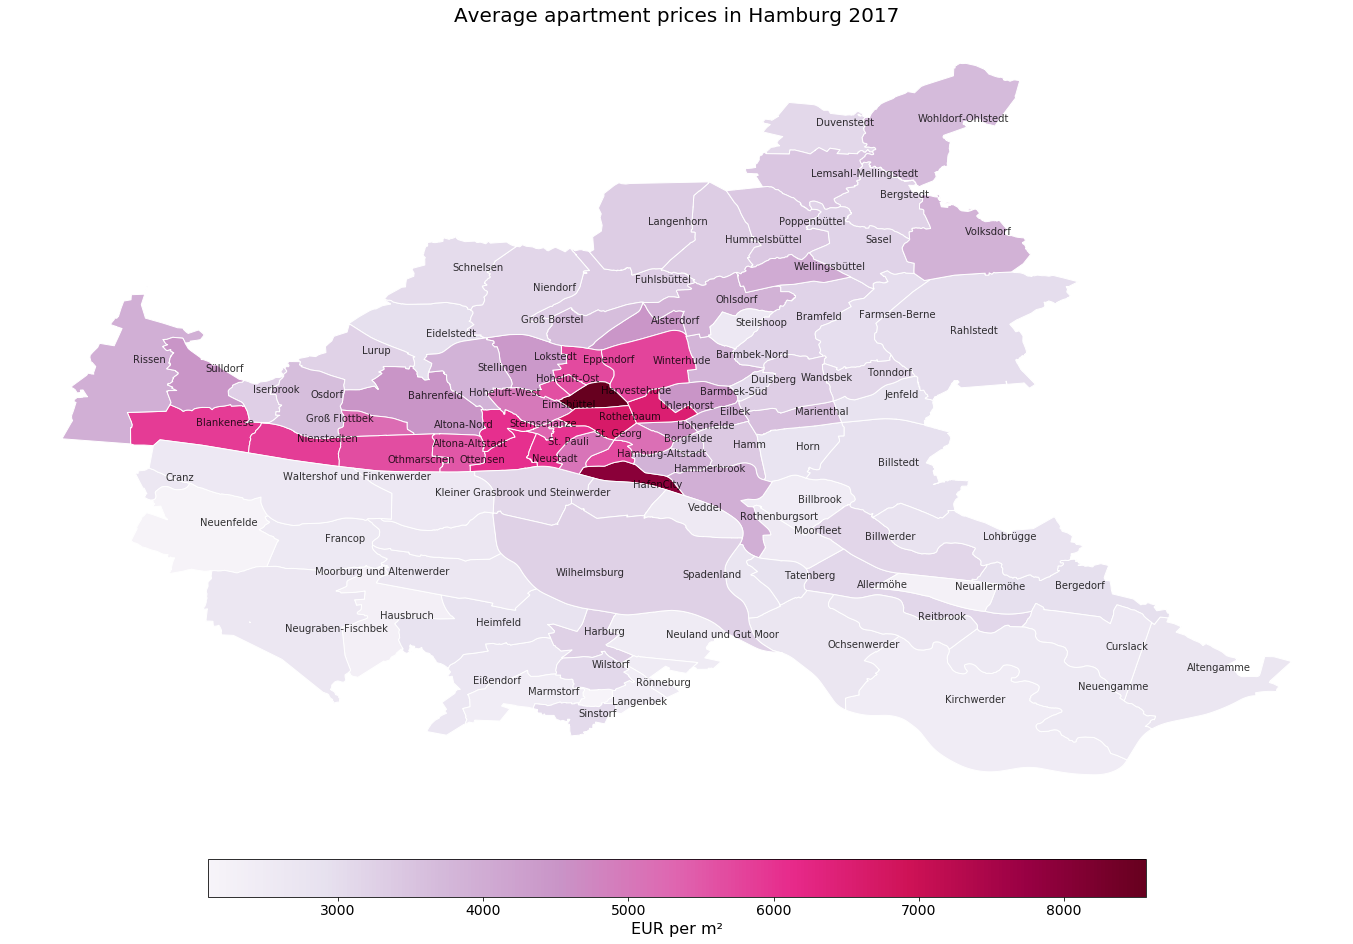

In [290]:
plot_variable_on_map(
    data,
    'average_apartment_price_per_m2',
    label="EUR per m²",
    title='Average apartment prices in Hamburg 2017',
    quantiles=False, 
    adjust_texts=True)